In [142]:
from js import fetch
from typing import List, Optional, Union

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import piplite
await piplite.install('seaborn')
await piplite.install('rbo')

import rbo
import seaborn as sns

In [143]:
# Generic GET call to a JSON endpoint 
async def get_json(url):
    resp = await fetch(url)
    resp_text = await resp.text()
    return json.loads(resp_text)

In [144]:
# Basic Quepid API client methods
async def get_cases():
    response = await get_json('/api/cases')
    return [{'id': case['case_id'], 'name': case['case_name']} for case in response['all_cases']]

async def get_snapshots(case):
    response = await get_json(f'/api/cases/{case}/snapshots?shallow=true')
    return [{'id': snapshot['id'], 'name': snapshot['name']} for snapshot in response['snapshots']]

async def get_cases_with_snapshots():
    cases = await get_cases()
    cases_with_snapshots = [{
        'id': case['id'],
        'name': case['name'],
        'snapshots': [ {
            'id': snapshot['id'],
            'name': snapshot['name']
        } for snapshot in (await get_snapshots(case['id'])) ]
    } for case in cases]
    return cases_with_snapshots

# Printing all cases and their snapshots
print("CASES / SNAPSHOTS AVAILABLE")
print("===========================")
for case_and_snapshots in (await get_cases_with_snapshots()):
    print(f"Case ID {case_and_snapshots['id']} (\"{case_and_snapshots['name']}\")")
    for snapshot in case_and_snapshots['snapshots']:
        print(f"  - Snapshot ID {snapshot['id']} (\"{snapshot['name']}\")")

CASES / SNAPSHOTS AVAILABLE
Case ID 6 ("test")
  - Snapshot ID 1 ("test1")
  - Snapshot ID 2 ("test2")
  - Snapshot ID 3 ("test3")
  - Snapshot ID 4 ("test4")
  - Snapshot ID 5 ("overview-boost")
  - Snapshot ID 6 ("all-equal")


In [161]:
# Load snapshot, return dict of queries and their (number of results, avg. score, [doc ids])
async def load_snapshot(case_id, snapshot_id):
    snapshot = await get_json(f'/api/cases/{case_id}/snapshots/{snapshot_id}')
    docs = snapshot['docs']
    queries = snapshot['queries']
    
    # scores are a list of dicts, group them by query
    scores_list = snapshot['scores']
    scores = {}
    for scores_dict in scores_list:
        scores[scores_dict['query_id']] = scores_dict
        
    return pd.DataFrame({
            "num_results": [scores[query['query_id']]['number_of_results'] for query in queries],
            "score": [scores[query['query_id']]['score'] for query in queries],
            "docs": [[doc['id'] for doc in docs[str(query['query_id'])] if doc['rated_only'] == False] for query in queries]
        },
        index=pd.Series(name='query', data=[query['query_text'] for query in queries])
    )

await load_snapshot(case_id=6, snapshot_id=5)

,num_results,score,docs
query,,,
star wars,781,0.2,"[354287, 322506, 53487, 4942, 12180, 43839, 14..."
star trek,337,0.0,"[9755, 10567, 121, 453755, 5683, 84203, 72190,..."
pulp fiction,52,0.0,"[18451, 43317, 10349, 10910, 398, 19723, 17769..."
Ghostbusters,3,1.0,"[2978, 620, 43074]"


In [162]:
def jaccard(l1, l2, max_n):
    if len(l1) == 0 and len(l2) == 0:
        return 1
    max_len = min(len(l1), len(l2), max_n)
    set1 = set(l1[:max_len])
    set2 = set(l2[:max_len])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return float(intersection) / union

async def load_snapshots(case_id1, snapshot_id1, case_id2, snapshot_id2):
    df_a = await load_snapshot(case_id1, snapshot_id1)
    df_b = await load_snapshot(case_id2, snapshot_id2)
    return df_a.merge(df_b, on='query')

async def compare(case_id1, snapshot_id1, case_id2, snapshot_id2):
    df = await load_snapshots(case_id1, snapshot_id1, case_id2, snapshot_id2)
    
    df['jaccard'] = df.apply(lambda row: jaccard(row['docs_x'], row['docs_y'], 10), axis=1)
    df['rbo'] = df.apply(lambda row: rbo.RankingSimilarity(row['docs_x'], row['docs_y']).rbo(), axis=1)
    df['score_delta'] = df['score_y'] - df['score_x']
    df.name = f"Case {case_id1} snapshot {snapshot_id1} vs. case {case_id1} snapshot {snapshot_id2}"
    return df

await compare(case_id1=6, snapshot_id1=5, case_id2=6, snapshot_id2=6)

,num_results_x,score_x,docs_x,num_results_y,score_y,docs_y,jaccard,rbo,score_delta
query,,,,,,,,,
star wars,781,0.2,"[354287, 322506, 53487, 4942, 12180, 43839, 14...",781,0.623299,"[11, 12180, 354287, 322506, 53487, 181808, 181...",0.250000,0.421587,0.423299
star trek,337,0.0,"[9755, 10567, 121, 453755, 5683, 84203, 72190,...",337,0.617103,"[9755, 13475, 188927, 54138, 193, 200, 201, 15...",0.111111,0.302897,0.617103
pulp fiction,52,0.0,"[18451, 43317, 10349, 10910, 398, 19723, 17769...",52,1.000000,"[680, 18451, 43317, 10349, 10910, 1262, 398, 1...",0.666667,0.642540,1.000000
Ghostbusters,3,1.0,"[2978, 620, 43074]",3,1.000000,"[43074, 620, 2978]",1.000000,0.500000,0.000000


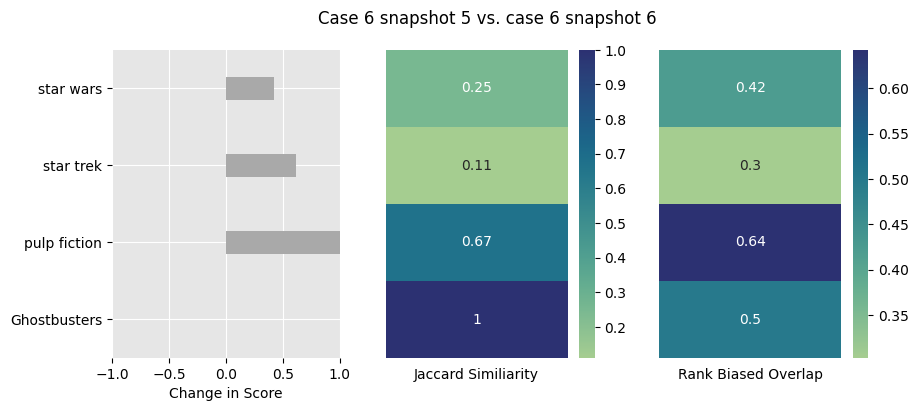

In [164]:
import matplotlib
matplotlib.rc_file_defaults()

def plot_compare(df):
    figure, axes = plt.subplots(1, 3, figsize=(10, 4))
    figure.suptitle(df.name)

    sns.barplot(ax=axes[0], x=df['score_delta'], y=df.index, width=0.3, color='darkgrey')
    axes[0].set(xlim=(-1, 1))
    axes[0].set_xlabel('Change in Score')
    axes[0].set_ylabel('')
    axes[0].set_facecolor((0.90, 0.90, 0.90))
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['bottom'].set_visible(False)
    axes[0].spines['left'].set_visible(False)
    axes[0].set_axisbelow(True)
    axes[0].xaxis.grid(color='w', linestyle='solid')
    axes[0].yaxis.grid(color='w', linestyle='solid')
    
    sns.heatmap(df[['jaccard']], ax=axes[1], cmap='crest', annot=True, xticklabels=False, yticklabels=False)
    axes[1].set_xlabel('Jaccard Similiarity')
    axes[1].set_ylabel('')
    
    sns.heatmap(df[['rbo']], ax=axes[2], cmap='crest', annot=True, xticklabels=False, yticklabels=False)
    axes[2].set_xlabel('Rank Biased Overlap')
    axes[2].set_ylabel('')
    
    plt.show()
    
df = await compare(6, 5, 6, 6)
plot_compare(df)